# DS681 Midterm Assignment - pt3
Abhinav Kumar

files: 13
rows: 819


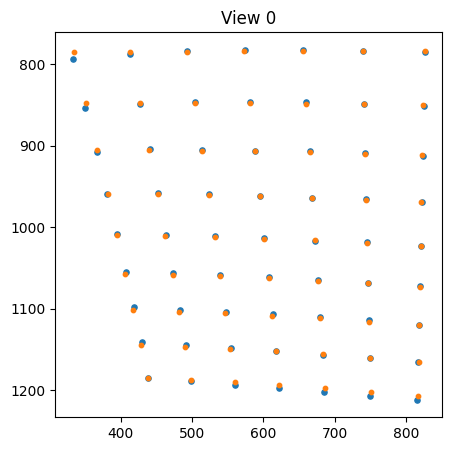

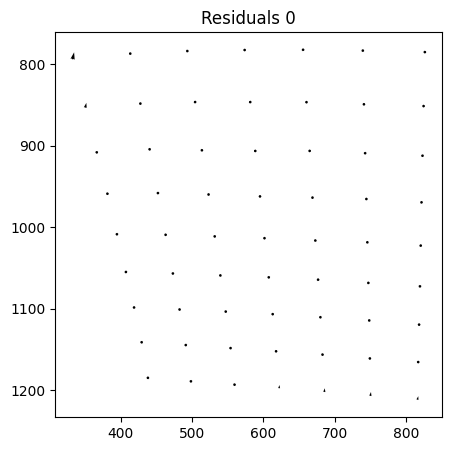

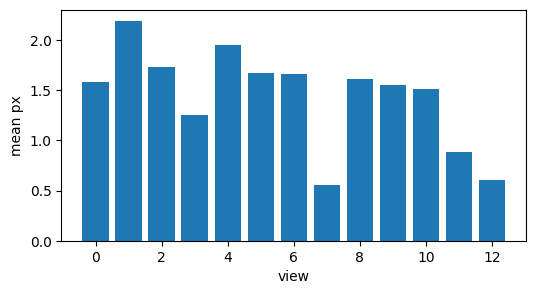

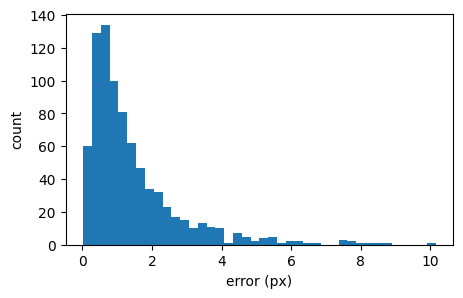

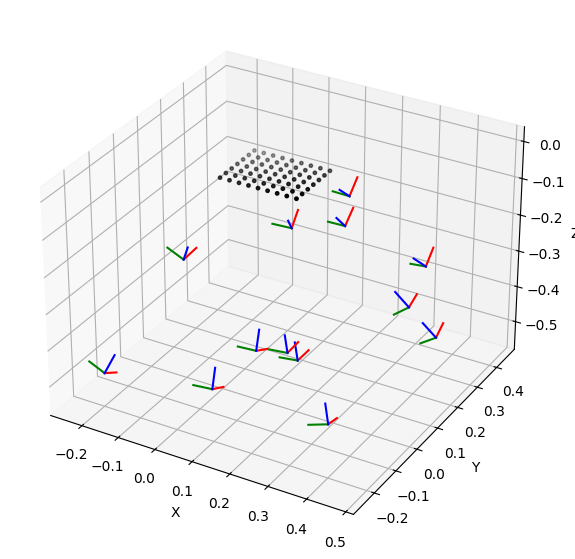

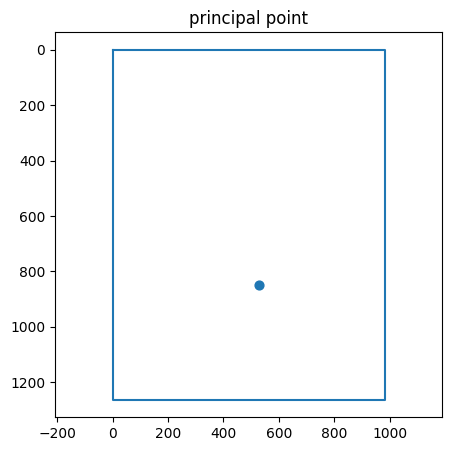

In [6]:
import glob, os, cv2, pandas as pd, numpy as np, torch, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

paths = sorted(glob.glob("phone_images/*.*"))
print("files:", len(paths))

CRIT=(cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER,50,1e-3)
rows=[]
for path in paths:
    img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    if img is None: continue
    ok,corners=cv2.findChessboardCornersSB(img,(9,7))
    if not ok: continue
    corners=cv2.cornerSubPix(img,corners,(5,5),(-1,-1),CRIT).reshape(-1,2)
    k=0
    for r in range(7):
        for c in range(9):
            u,v=corners[k]
            rows.append([os.path.basename(path),float(u),float(v),c,r,0.025*c,0.025*r])
            k+=1

df = pd.DataFrame(rows, columns=["image_id","u","v","col","row","X","Y"])
print("rows:", len(df))
if df.empty:
    raise SystemExit("no corners found; check folder or pattern size")

COL_IMAGE, COL_U, COL_V, COL_X, COL_Y, COL_R, COL_C = "image_id","u","v","X","Y","row","col"
O=[]; I=[]
for _,g in df.sort_values([COL_IMAGE,COL_R,COL_C]).groupby(COL_IMAGE):
    obj=np.stack([g[COL_X].to_numpy(), g[COL_Y].to_numpy(), np.zeros(len(g))],1).astype(np.float32)
    img=g[[COL_U,COL_V]].to_numpy(np.float32)
    if np.isfinite(obj).all() and np.isfinite(img).all() and len(obj)==len(img) and len(obj)>=6:
        H,_=cv2.findHomography(obj[:,:2], img, method=0)
        if H is not None:
            O.append(obj); I.append(img)

if len(O)<3:
    raise SystemExit("need at least 3 valid views")

u_max=int(max(i[:,0].max() for i in I)); v_max=int(max(i[:,1].max() for i in I))
w,h=u_max+1,v_max+1
f=float(max(w,h))
K0=np.array([[f,0,w/2],[0,f,h/2],[0,0,1]],np.float64)
ret,K_cv,dist_cv,rvecs_cv,tvecs_cv=cv2.calibrateCamera(O,I,(w,h),K0,None,flags=cv2.CALIB_USE_INTRINSIC_GUESS)

def from_r(r): return cv2.Rodrigues(r.reshape(3,1))[0]
intr=torch.tensor([K_cv[0,0],K_cv[1,1],K_cv[0,1],K_cv[0,2],K_cv[1,2]],dtype=torch.double,requires_grad=True)
dist=torch.zeros(5,dtype=torch.double,requires_grad=True)
r_all=torch.tensor(np.stack([r.reshape(3) for r in rvecs_cv]),dtype=torch.double,requires_grad=True)
t_all=torch.tensor(np.stack([t.reshape(3) for t in tvecs_cv]),dtype=torch.double,requires_grad=True)

def proj(obj_np,intr,dist,r,t):
    fx,fy,s,cx,cy=intr; k1,k2,p1,p2,k3=dist
    R=torch.from_numpy(from_r(r.detach().cpu().numpy())).double()
    X=torch.from_numpy(obj_np.T.astype(np.float64))
    Xc=(R@X)+t.view(3,1)
    x=Xc[0]/Xc[2]; y=Xc[1]/Xc[2]
    r2=x*x+y*y
    radial=1+k1*r2+k2*r2*r2+k3*r2*r2*r2
    xt=x*radial+2*p1*x*y+p2*(r2+2*x*x)
    yt=y*radial+p1*(r2+2*y*y)+2*p2*x*y
    u=fx*xt+s*yt+cx
    v=fy*yt+cy
    return torch.stack([u,v],1)

opt=torch.optim.Adam([intr,dist,r_all,t_all],lr=1e-3)
for _ in range(800):
    opt.zero_grad(set_to_none=True)
    L=0.0
    for j in range(len(O)):
        pred=proj(O[j],intr,dist,r_all[j],t_all[j])
        gt=torch.from_numpy(I[j].astype(np.float64))
        L+=torch.mean((pred-gt)**2)
    (L/len(O)).backward(); opt.step()

fx,fy,s,cx,cy=intr.detach().numpy()
K_ref=np.array([[fx,s,cx],[0.,fy,cy],[0.,0.,1.]],np.float64)
dist_ref=dist.detach().numpy()

i=0
p,_=cv2.projectPoints(O[i],r_all.detach().numpy()[i].reshape(3,1),t_all.detach().numpy()[i].reshape(3,1),K_ref,dist_ref)
plt.figure(figsize=(5,5))
plt.scatter(I[i][:,0],I[i][:,1],s=14)
plt.scatter(p[:,0,0],p[:,0,1],s=10)
plt.gca().invert_yaxis()
plt.title(f"View {i}")
plt.show()

p=p.reshape(-1,2); d=p-I[i]
plt.figure(figsize=(5,5))
plt.quiver(I[i][:,0],I[i][:,1],d[:,0],d[:,1],angles='xy',scale_units='xy',scale=1)
plt.gca().invert_yaxis()
plt.title(f"Residuals {i}")
plt.show()

errs=[]
for j in range(len(O)):
    p,_=cv2.projectPoints(O[j],r_all.detach().numpy()[j].reshape(3,1),t_all.detach().numpy()[j].reshape(3,1),K_ref,dist_ref)
    e=np.linalg.norm(p.reshape(-1,2)-I[j],axis=1).mean()
    errs.append(e)
plt.figure(figsize=(6,3))
plt.bar(range(len(errs)),errs)
plt.xlabel("view"); plt.ylabel("mean px")
plt.show()

E=[]
for j in range(len(O)):
    p,_=cv2.projectPoints(O[j],r_all.detach().numpy()[j].reshape(3,1),t_all.detach().numpy()[j].reshape(3,1),K_ref,dist_ref)
    E.extend(np.linalg.norm(p.reshape(-1,2)-I[j],axis=1))
plt.figure(figsize=(5,3))
plt.hist(E,bins=40)
plt.xlabel("error (px)"); plt.ylabel("count")
plt.show()

fig=plt.figure(figsize=(7,7)); ax=fig.add_subplot(111,projection='3d')
def draw_cam(ax,R,t,s=0.05):
    o=-R.T@t; a=R.T*s
    ax.plot([o[0],o[0]+a[0,0]],[o[1],o[1]+a[1,0]],[o[2],o[2]+a[2,0]],c='r')
    ax.plot([o[0],o[0]+a[0,1]],[o[1],o[1]+a[1,1]],[o[2],o[2]+a[2,1]],c='g')
    ax.plot([o[0],o[0]+a[0,2]],[o[1],o[1]+a[1,2]],[o[2],o[2]+a[2,2]],c='b')
for r,t in zip(r_all.detach().numpy(),t_all.detach().numpy()):
    R,_=cv2.Rodrigues(r.reshape(3,1)); draw_cam(ax,R,t)
B=O[0]; ax.scatter(B[:,0],B[:,1],B[:,2],s=6,c='k')
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.show()

w=int(max(i[:,0].max() for i in I))+1
h=int(max(i[:,1].max() for i in I))+1
cx,cy=K_ref[0,2],K_ref[1,2]
plt.figure(figsize=(5,5))
plt.plot([0,w,w,0,0],[0,0,h,h,0])
plt.scatter([cx],[cy],s=40)
plt.gca().invert_yaxis(); plt.axis("equal")
plt.title("principal point")
plt.show()
